## Описание проекта

Компания оптимизирет производственные расходы, необходимо разработать модель для предсказания последнего измерения температуры стали.

#### Задачи проекта

Предсказать последнюю температуру стали с низкой метрикой МАЕ. Меньше 8.7 приемлимо, меньше 6 идеально.

#### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Содержание <a name="title"></a>

[Импорт библиотек и задание констант](#import)
1. [Загрузка и подготовка данных](#1)
 
 
2. [Обучение и проверка модели](#2)

    
3. [Тестирование](#3)


4. [Отчёт](#4)

    4.1 [Какие пункты плана были выполнены, а какие — нет (поясните почему)?](#4.1)
    
    4.2 [Какие трудности возникли и как вы их преодолели?](#4.2)
        
    4.3 [Какие ключевые шаги в решении задачи выделили?](#4.3)
            
    4.4 [Какая ваша итоговая модель и какое у неё качество?](#4.4)

## Импорт библиотек и функций <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
#import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor

RNG = 34


def review(data, i):
    return pd.concat([data.head(i), data.tail(i)], keys=['head', 'tail'])

[Содержание](#title)

## 1. Загрузка и подготовка данных <a name="1"></a>

In [2]:
data_arc = pd.read_csv('/Users/Alexey/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/Users/Alexey/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/Users/Alexey/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/Users/Alexey/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/Users/Alexey/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/Users/Alexey/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/Users/Alexey/datasets/final_steel/data_wire_time.csv')

Перед загрузкой все данные были просмотрены и проанализированы при помощи библиотеки `pandas_profiling`. Самые необходимые результаты анализа были отображены в проекте

In [4]:
review(data_temp, 5)

key         Время замера  Температура
head 0         1  2019-05-03 11:16:18       1571.0
     1         1  2019-05-03 11:25:53       1604.0
     2         1  2019-05-03 11:29:11       1618.0
     3         1  2019-05-03 11:30:01       1601.0
     4         1  2019-05-03 11:30:39       1613.0
tail 15902  3241  2019-09-01 04:03:30       1586.0
     15903  3241  2019-09-01 04:16:12          NaN
     15904  3241  2019-09-01 04:22:39          NaN
     15905  3241  2019-09-01 04:33:42          NaN
     15906  3241  2019-09-01 04:38:08          NaN

In [5]:
len(data_temp['key'].unique())

3216

На основе данной таблицы будем строить полный датасет. Пропуски в температуре не несут полезной информации, от них избавимся.

In [6]:
data_temp.dropna(inplace=True)
data_temp = data_temp.reset_index(drop=True)

In [7]:
print(len(data_temp))
len(data_temp['key'].unique())

13006


3216

Выборка сократилась почти на 3 тысячи строк. Количество партий не изменилось.

In [8]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13006 entries, 0 to 13005
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13006 non-null  int64  
 1   Время замера  13006 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 305.0+ KB


Необходимо изменить тип данных в столбце **Время замера**

In [9]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

Рассмотрим временной ряд

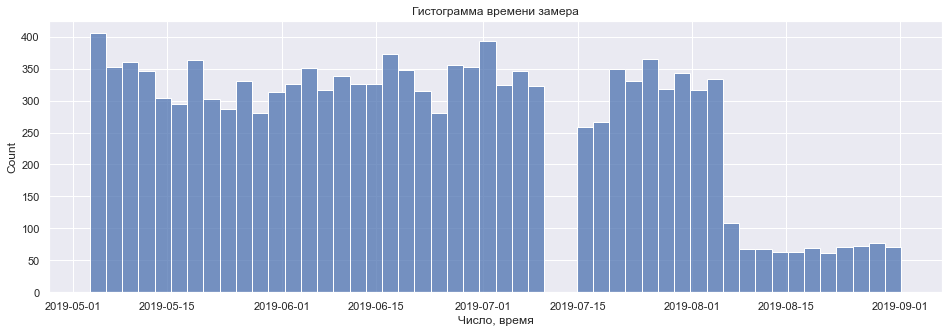

In [10]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(16,5))
ax = sns.histplot(x="Время замера", data=data_temp, bins=50)
plt.title("Гистограмма времени замера")
ax.set_xlabel('Число, время')
plt.show()

В датасете выборка за 4 месяца. В июле был разрыв в данных.

В последнем месяце резко сократилось колличество измерений температуры в партиях. Ещё раз рассмотрим датасет

In [11]:
review(data_temp, 5)

key        Время замера  Температура
head 0         1 2019-05-03 11:16:18       1571.0
     1         1 2019-05-03 11:25:53       1604.0
     2         1 2019-05-03 11:29:11       1618.0
     3         1 2019-05-03 11:30:01       1601.0
     4         1 2019-05-03 11:30:39       1613.0
tail 13001  3237 2019-08-31 22:44:04       1569.0
     13002  3238 2019-08-31 23:30:31       1584.0
     13003  3239 2019-09-01 01:31:47       1598.0
     13004  3240 2019-09-01 02:39:01       1617.0
     13005  3241 2019-09-01 04:03:30       1586.0

По условию задания мы знаем первую измеренную температуру и должны предсказать последнюю измеренную. Удалим из датасета партии с одним измерением

In [12]:
key_count = data_temp.groupby('key')['Температура'].count()

In [13]:
true_key = key_count[key_count != 1].index

In [14]:
data_temp = data_temp.query('key in @true_key').reset_index(drop=True)

In [15]:
review(data_temp, 5)

key        Время замера  Температура
head 0         1 2019-05-03 11:16:18       1571.0
     1         1 2019-05-03 11:25:53       1604.0
     2         1 2019-05-03 11:29:11       1618.0
     3         1 2019-05-03 11:30:01       1601.0
     4         1 2019-05-03 11:30:39       1613.0
tail 12260  2498 2019-08-06 02:19:26       1593.0
     12261  2498 2019-08-06 02:25:31       1594.0
     12262  2499 2019-08-06 02:40:25       1569.0
     12263  2499 2019-08-06 02:54:24       1604.0
     12264  2499 2019-08-06 03:00:28       1603.0

Создадим общий датасет с новыми признаками

In [16]:
df = pd.DataFrame(columns=['key', 'time', 'temp', 'temp_before', 'time_before'])

ind = 0
for i in data_temp['key'].unique():
    df.loc[ind, 'key'] = i
    df.loc[ind, 'time'] = data_temp.query('key == @i').reset_index(drop=True).loc[key_count[i]-1, 'Время замера']
    df.loc[ind, 'temp'] = data_temp.query('key == @i').reset_index(drop=True).loc[key_count[i]-1, 'Температура']
    df.loc[ind, 'temp_before'] = data_temp.query('key == @i').reset_index(drop=True).loc[0, 'Температура']
    df.loc[ind, 'time_before'] = data_temp.query('key == @i').reset_index(drop=True).loc[0, 'Время замера']
    ind += 1

Проверка

In [17]:
review(df, 5)

key                 time  temp temp_before          time_before
head 0        1  2019-05-03 11:30:39  1613        1571  2019-05-03 11:16:18
     1        2  2019-05-03 11:59:12  1602        1581  2019-05-03 11:37:27
     2        3  2019-05-03 12:34:57  1599        1596  2019-05-03 12:13:17
     3        4  2019-05-03 12:59:25  1625        1601  2019-05-03 12:52:57
     4        5  2019-05-03 13:36:01  1602        1576  2019-05-03 13:23:19
tail 2470  2495  2019-08-06 00:54:42  1591        1570  2019-08-06 00:35:45
     2471  2496  2019-08-06 01:29:52  1591        1554  2019-08-06 01:02:54
     2472  2497  2019-08-06 01:53:50  1589        1571  2019-08-06 01:41:53
     2473  2498  2019-08-06 02:25:31  1594        1591  2019-08-06 02:03:49
     2474  2499  2019-08-06 03:00:28  1603        1569  2019-08-06 02:40:25

In [18]:
df['time'] = pd.to_datetime(df['time'])
df['key'] = df['key'].astype('int')
df['temp'] = df['temp'].astype('float')
df['temp_before'] = df['temp_before'].astype('float')
df['time_before'] = pd.to_datetime(df['time_before'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          2475 non-null   int32         
 1   time         2475 non-null   datetime64[ns]
 2   temp         2475 non-null   float64       
 3   temp_before  2475 non-null   float64       
 4   time_before  2475 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int32(1)
memory usage: 186.3 KB


Исследуем наличие аномалий температуры в полученном наборе данных

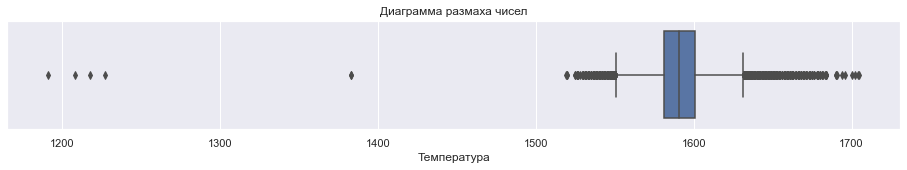

In [20]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(16,2))
ax = sns.boxplot(x="Температура", data=data_temp)
plt.title("Диаграмма размаха чисел")
ax.set_xlabel('Температура')
plt.show()

Если говорить о теории выбросов, то интервал q3+3iqr с очень высокой вероятностью  говорит о грубых выбросах. Да данных значениях модель не сможет адекватно обучиться. Удалим данные значения из обучающей выборки и сообщим о номерах этих партий заказчику, чтобы уточнить информацию о них в будущем.

Для разработки production-ready моделей можно будет обратиться к природе процесса и выясниснить справочные температуры плавления конкретных сплавов.

In [21]:
Q1 =  df['temp'].quantile(0.25)
Q3 = df['temp'].quantile(0.75)
IQR = Q3 - Q1
df_bad = df.query("(temp < @Q1 - 3*@IQR) or (temp > @Q3 + 3*@IQR)").reset_index(drop=True)
df = df.query("@Q1 - 3*@IQR < temp < @Q3 + 3*@IQR").reset_index(drop=True)

In [22]:
print(f'Замеры с нетипичной температурой для заказчика, {len(df_bad)} значений')
review(df_bad, 5)

Замеры с нетипичной температурой для заказчика, 86 значений


key                time    temp  temp_before         time_before
head 0     51 2019-05-05 06:10:21  1690.0       1619.0 2019-05-05 05:48:48
     1     52 2019-05-05 06:54:08  1669.0       1617.0 2019-05-05 06:21:58
     2     53 2019-05-05 07:38:14  1671.0       1642.0 2019-05-05 07:04:58
     3     54 2019-05-05 08:18:57  1663.0       1630.0 2019-05-05 07:49:38
     4     55 2019-05-05 08:57:46  1654.0       1615.0 2019-05-05 08:27:17
tail 81  2389 2019-08-02 07:44:39  1646.0       1653.0 2019-08-02 07:29:15
     82  2390 2019-08-02 08:22:39  1648.0       1679.0 2019-08-02 08:16:44
     83  2391 2019-08-02 09:06:45  1644.0       1623.0 2019-08-02 08:44:19
     84  2392 2019-08-02 09:36:30  1650.0       1623.0 2019-08-02 09:19:01
     85  2393 2019-08-02 10:12:01  1648.0       1637.0 2019-08-02 09:52:48

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          2388 non-null   int32         
 1   time         2388 non-null   datetime64[ns]
 2   temp         2388 non-null   float64       
 3   temp_before  2388 non-null   float64       
 4   time_before  2388 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int32(1)
memory usage: 84.1 KB


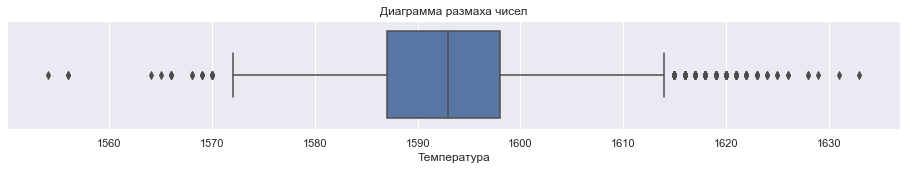

In [24]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(16,2))
ax = sns.boxplot(x="temp", data=df)
plt.title("Диаграмма размаха чисел")
ax.set_xlabel('Температура')
plt.show()

Расмотрим датасеты с проволочными материалами

In [25]:
review(data_wire_time, 5)

key               Wire 1               Wire 2 Wire 3 Wire 4  \
head 0        1  2019-05-03 11:11:41                  NaN    NaN    NaN   
     1        2  2019-05-03 11:46:10                  NaN    NaN    NaN   
     2        3  2019-05-03 12:13:47                  NaN    NaN    NaN   
     3        4  2019-05-03 12:48:05                  NaN    NaN    NaN   
     4        5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN   
tail 3076  3237  2019-08-31 22:50:20                  NaN    NaN    NaN   
     3077  3238  2019-08-31 23:38:24                  NaN    NaN    NaN   
     3078  3239  2019-09-01 01:50:43                  NaN    NaN    NaN   
     3079  3240  2019-09-01 03:12:02                  NaN    NaN    NaN   
     3080  3241  2019-09-01 04:16:01                  NaN    NaN    NaN   

          Wire 5 Wire 6 Wire 7 Wire 8 Wire 9  
head 0       NaN    NaN    NaN    NaN    NaN  
     1       NaN    NaN    NaN    NaN    NaN  
     2       NaN    NaN    NaN    NaN    NaN  
     3       NaN    NaN    NaN    NaN    NaN  
     4       NaN    NaN    NaN    NaN    NaN  
tail 3076    NaN    NaN    NaN    NaN    NaN  
     3077    NaN    NaN    NaN    NaN    NaN  
     3078    NaN    NaN    NaN    NaN    NaN  
     3079    NaN    NaN    NaN    NaN    NaN  
     3080    NaN    NaN    NaN    NaN    NaN

In [26]:
review(data_wire, 5)

key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
head 0        1   60.059998      NaN     NaN     NaN     NaN     NaN     NaN   
     1        2   96.052315      NaN     NaN     NaN     NaN     NaN     NaN   
     2        3   91.160157      NaN     NaN     NaN     NaN     NaN     NaN   
     3        4   89.063515      NaN     NaN     NaN     NaN     NaN     NaN   
     4        5   89.238236  9.11456     NaN     NaN     NaN     NaN     NaN   
tail 3076  3237   38.088959      NaN     NaN     NaN     NaN     NaN     NaN   
     3077  3238   56.128799      NaN     NaN     NaN     NaN     NaN     NaN   
     3078  3239  143.357761      NaN     NaN     NaN     NaN     NaN     NaN   
     3079  3240   34.070400      NaN     NaN     NaN     NaN     NaN     NaN   
     3080  3241   63.117595      NaN     NaN     NaN     NaN     NaN     NaN   

           Wire 8  Wire 9  
head 0        NaN     NaN  
     1        NaN     NaN  
     2        NaN     NaN  
     3        NaN     NaN  
     4        NaN     NaN  
tail 3076     NaN     NaN  
     3077     NaN     NaN  
     3078     NaN     NaN  
     3079     NaN     NaN  
     3080     NaN     NaN

In [27]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В наборе данных много пропусков. Заполним их 0

In [28]:
data_wire.fillna(0, inplace=True)

Добавим столбец с количеством добавленных типов проволоки в партию

In [29]:
data_wire['max count'] = sum([data_wire['Wire 1'] != 0, data_wire['Wire 2'] != 0,\
                              data_wire['Wire 3'] != 0, data_wire['Wire 4'] != 0,\
                             data_wire['Wire 5'] != 0, data_wire['Wire 6'] != 0,\
                             data_wire['Wire 7'] != 0, data_wire['Wire 8'] != 0,\
                             data_wire['Wire 9'] != 0])

In [30]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,max count
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [31]:
data_wire['max count'].max()

5

Если бы типов проволоки было меньше, то можно было бы создать столбцы с номером проволоки и её количеством, но данном случае типов много и проще добавить количество каждой проволоки в общий датасет

При добавлении в общий датасет будем проверять время добавления. Отсутвующие значения времени заполним нетипичными из будущего

In [32]:
data_wire_time = data_wire_time.fillna('2021-01-01 11:11:11')

In [33]:
columns_wire = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',\
         'Wire 7', 'Wire 8', 'Wire 9']

In [34]:
for column in columns_wire:
    data_wire_time[column] = pd.to_datetime(data_wire_time[column])

In [35]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3081 non-null   datetime64[ns]
 2   Wire 2  3081 non-null   datetime64[ns]
 3   Wire 3  3081 non-null   datetime64[ns]
 4   Wire 4  3081 non-null   datetime64[ns]
 5   Wire 5  3081 non-null   datetime64[ns]
 6   Wire 6  3081 non-null   datetime64[ns]
 7   Wire 7  3081 non-null   datetime64[ns]
 8   Wire 8  3081 non-null   datetime64[ns]
 9   Wire 9  3081 non-null   datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [36]:
for column in columns_wire:
    df[column] = 0

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          2388 non-null   int32         
 1   time         2388 non-null   datetime64[ns]
 2   temp         2388 non-null   float64       
 3   temp_before  2388 non-null   float64       
 4   time_before  2388 non-null   datetime64[ns]
 5   Wire 1       2388 non-null   int64         
 6   Wire 2       2388 non-null   int64         
 7   Wire 3       2388 non-null   int64         
 8   Wire 4       2388 non-null   int64         
 9   Wire 5       2388 non-null   int64         
 10  Wire 6       2388 non-null   int64         
 11  Wire 7       2388 non-null   int64         
 12  Wire 8       2388 non-null   int64         
 13  Wire 9       2388 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(9)
memory usage: 252.0 KB


In [38]:
for i in range(len(df)):
    k = df.loc[i, 'key']
    for column in columns_wire:
        try:
            if (df.loc[i, 'time'] > data_wire_time.query('key == @k')[column].reset_index(drop=True))[0]:
                df.loc[i, column] = float(data_wire.query('key == @k')[column])
            else:
                df.loc[i, column] = float(0)
        except:
            df.loc[i, column] = float(0)

In [39]:
df.head(10)

,key,time,temp,temp_before,time_before,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:30:39,1613.0,1571.0,2019-05-03 11:16:18,60.059998,0.000000,0.0,0.0,0,0.0,0,0.0,0.0
1,2,2019-05-03 11:59:12,1602.0,1581.0,2019-05-03 11:37:27,96.052315,0.000000,0.0,0.0,0,0.0,0,0.0,0.0
2,3,2019-05-03 12:34:57,1599.0,1596.0,2019-05-03 12:13:17,91.160157,0.000000,0.0,0.0,0,0.0,0,0.0,0.0
3,4,2019-05-03 12:59:25,1625.0,1601.0,2019-05-03 12:52:57,89.063515,0.000000,0.0,0.0,0,0.0,0,0.0,0.0
4,5,2019-05-03 13:36:01,1602.0,1576.0,2019-05-03 13:23:19,89.238236,9.114560,0.0,0.0,0,0.0,0,0.0,0.0
5,6,2019-05-03 14:12:29,1596.0,1543.0,2019-05-03 13:49:24,99.109917,9.114560,0.0,0.0,0,0.0,0,0.0,0.0
6,7,2019-05-03 14:42:37,1599.0,1586.0,2019-05-03 14:19:43,98.061600,0.000000,0.0,0.0,0,0.0,0,0.0,0.0
7,8,2019-05-03 15:22:52,1598.0,1577.0,2019-05-03 15:07:18,155.282394,0.000000,0.0,0.0,0,0.0,0,0.0,0.0
8,9,2019-05-03 16:01:16,1592.0,1587.0,2019-05-03 15:37:03,113.393279,9.143681,0.0,0.0,0,0.0,0,0.0,0.0
9,10,2019-05-03 16:36:08,1593.0,1574.0,2019-05-03 16:14:29,81.244796,12.376000,0.0,0.0,0,0.0,0,0.0,0.0


Заполнено корректно

Расмотрим датасеты с засыпными материалами

In [40]:
review(data_bulk_time, 5)

key Bulk 1 Bulk 2               Bulk 3               Bulk 4  \
head 0        1    NaN    NaN                  NaN  2019-05-03 11:21:30   
     1        2    NaN    NaN                  NaN  2019-05-03 11:46:38   
     2        3    NaN    NaN                  NaN  2019-05-03 12:31:06   
     3        4    NaN    NaN                  NaN  2019-05-03 12:48:43   
     4        5    NaN    NaN                  NaN  2019-05-03 13:18:50   
tail 3124  3237    NaN    NaN  2019-08-31 22:51:28                  NaN   
     3125  3238    NaN    NaN  2019-08-31 23:39:11                  NaN   
     3126  3239    NaN    NaN                  NaN                  NaN   
     3127  3240    NaN    NaN                  NaN                  NaN   
     3128  3241    NaN    NaN                  NaN                  NaN   

          Bulk 5               Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11  \
head 0       NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
     1       NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
     2       NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
     3       NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
     4       NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
tail 3124    NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
     3125    NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
     3126    NaN  2019-09-01 01:51:58    NaN    NaN    NaN     NaN     NaN   
     3127    NaN  2019-09-01 03:12:40    NaN    NaN    NaN     NaN     NaN   
     3128    NaN                  NaN    NaN    NaN    NaN     NaN     NaN   

                       Bulk 12 Bulk 13              Bulk 14  \
head 0     2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
     1     2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
     2     2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
     3     2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
     4     2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   
tail 3124  2019-08-31 22:46:52     NaN  2019-08-31 22:46:52   
     3125  2019-08-31 23:33:09     NaN  2019-08-31 23:33:09   
     3126  2019-09-01 01:39:41     NaN  2019-09-01 01:33:25   
     3127                  NaN     NaN  2019-09-01 02:41:27   
     3128                  NaN     NaN  2019-09-01 04:05:34   

                       Bulk 15  
head 0     2019-05-03 11:03:52  
     1     2019-05-03 11:40:20  
     2     2019-05-03 12:09:40  
     3     2019-05-03 12:41:24  
     4     2019-05-03 13:12:56  
tail 3124  2019-08-31 22:46:52  
     3125  2019-08-31 23:33:09  
     3126  2019-09-01 01:33:25  
     3127  2019-09-01 02:41:27  
     3128  2019-09-01 04:05:34

In [41]:
review(data_bulk, 5)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  \
head 0        1     NaN     NaN     NaN    43.0     NaN     NaN     NaN   
     1        2     NaN     NaN     NaN    73.0     NaN     NaN     NaN   
     2        3     NaN     NaN     NaN    34.0     NaN     NaN     NaN   
     3        4     NaN     NaN     NaN    81.0     NaN     NaN     NaN   
     4        5     NaN     NaN     NaN    78.0     NaN     NaN     NaN   
tail 3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN   
     3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN   
     3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN   
     3127  3240     NaN     NaN     NaN     NaN     NaN    26.0     NaN   
     3128  3241     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

           Bulk 8  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  \
head 0        NaN     NaN      NaN      NaN    206.0      NaN    150.0   
     1        NaN     NaN      NaN      NaN    206.0      NaN    149.0   
     2        NaN     NaN      NaN      NaN    205.0      NaN    152.0   
     3        NaN     NaN      NaN      NaN    207.0      NaN    153.0   
     4        NaN     NaN      NaN      NaN    203.0      NaN    151.0   
tail 3124     NaN     NaN      NaN      NaN    252.0      NaN    130.0   
     3125     NaN     NaN      NaN      NaN    254.0      NaN    108.0   
     3126     NaN     NaN      NaN      NaN    158.0      NaN    270.0   
     3127     NaN     NaN      NaN      NaN      NaN      NaN    192.0   
     3128     NaN     NaN      NaN      NaN      NaN      NaN    180.0   

           Bulk 15  
head 0       154.0  
     1       154.0  
     2       153.0  
     3       154.0  
     4       152.0  
tail 3124    206.0  
     3125    106.0  
     3126     88.0  
     3127     54.0  
     3128     52.0

In [42]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [43]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Заполним нулями датасет с массой материала

In [44]:
data_bulk.fillna(0, inplace=True)

Добавим столбец с количеством добавленных типов засупки в партию

In [45]:
data_bulk['max count'] = sum([data_bulk['Bulk 1'] != 0, data_bulk['Bulk 2'] != 0,\
                              data_bulk['Bulk 3'] != 0, data_bulk['Bulk 4'] != 0,\
                             data_bulk['Bulk 5'] != 0, data_bulk['Bulk 6'] != 0,\
                             data_bulk['Bulk 7'] != 0, data_bulk['Bulk 8'] != 0,\
                             data_bulk['Bulk 9'] != 0, data_bulk['Bulk 10'] != 0,\
                             data_bulk['Bulk 11'] != 0, data_bulk['Bulk 12'] != 0,\
                             data_bulk['Bulk 13'] != 0, data_bulk['Bulk 14'] != 0,\
                             data_bulk['Bulk 15'] != 0,])

In [46]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,max count
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4


In [47]:
data_bulk['max count'].max()

7

В некоторых партиях колчичество типов добавок очень высоко, необходимо добавить все столбцы в общий датасет

При добавлении в общий датасет будем проверять время добавления. Отсутвующие значения времени заполним нетипичными из будущего

In [48]:
data_bulk_time.fillna('2021-01-01 11:11:11', inplace=True)

In [49]:
columns_bulk = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',\
                 'Bulk 7', 'Bulk 8', 'Bulk 9','Bulk 10', 'Bulk 11', 'Bulk 12',\
                'Bulk 13', 'Bulk 14', 'Bulk 15']

In [50]:
for column in columns_bulk:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column])

In [51]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   3129 non-null   datetime64[ns]
 2   Bulk 2   3129 non-null   datetime64[ns]
 3   Bulk 3   3129 non-null   datetime64[ns]
 4   Bulk 4   3129 non-null   datetime64[ns]
 5   Bulk 5   3129 non-null   datetime64[ns]
 6   Bulk 6   3129 non-null   datetime64[ns]
 7   Bulk 7   3129 non-null   datetime64[ns]
 8   Bulk 8   3129 non-null   datetime64[ns]
 9   Bulk 9   3129 non-null   datetime64[ns]
 10  Bulk 10  3129 non-null   datetime64[ns]
 11  Bulk 11  3129 non-null   datetime64[ns]
 12  Bulk 12  3129 non-null   datetime64[ns]
 13  Bulk 13  3129 non-null   datetime64[ns]
 14  Bulk 14  3129 non-null   datetime64[ns]
 15  Bulk 15  3129 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [52]:
for column in columns_bulk:
    df[column] = 0

In [53]:
for i in range(len(df)):
    k = df.loc[i, 'key']
    for column in columns_bulk:
        try:
            if (df.loc[i, 'time'] > data_bulk_time.query('key == @k')[column].reset_index(drop=True))[0]:
                df.loc[i, column] = float(data_bulk.query('key == @k')[column])
            else:
                df.loc[i, column] = float(0)
        except:
            df.loc[i, column] = float(0)

In [54]:
df.head(10)

,key,time,temp,temp_before,time_before,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:30:39,1613.0,1571.0,2019-05-03 11:16:18,60.059998,0.000000,0.0,0.0,0,...,0,0,0,0,0,0,206,0,150,154
1,2,2019-05-03 11:59:12,1602.0,1581.0,2019-05-03 11:37:27,96.052315,0.000000,0.0,0.0,0,...,0,0,0,0,0,0,206,0,149,154
2,3,2019-05-03 12:34:57,1599.0,1596.0,2019-05-03 12:13:17,91.160157,0.000000,0.0,0.0,0,...,0,0,0,0,0,0,205,0,152,153
3,4,2019-05-03 12:59:25,1625.0,1601.0,2019-05-03 12:52:57,89.063515,0.000000,0.0,0.0,0,...,0,0,0,0,0,0,207,0,153,154
4,5,2019-05-03 13:36:01,1602.0,1576.0,2019-05-03 13:23:19,89.238236,9.114560,0.0,0.0,0,...,0,0,0,0,0,0,203,0,151,152
5,6,2019-05-03 14:12:29,1596.0,1543.0,2019-05-03 13:49:24,99.109917,9.114560,0.0,0.0,0,...,0,0,0,0,0,0,204,0,201,154
6,7,2019-05-03 14:42:37,1599.0,1586.0,2019-05-03 14:19:43,98.061600,0.000000,0.0,0.0,0,...,0,0,0,0,0,0,204,0,152,154
7,8,2019-05-03 15:22:52,1598.0,1577.0,2019-05-03 15:07:18,155.282394,0.000000,0.0,0.0,0,...,0,0,0,0,0,0,410,0,252,153
8,9,2019-05-03 16:01:16,1592.0,1587.0,2019-05-03 15:37:03,113.393279,9.143681,0.0,0.0,0,...,0,0,0,0,0,0,107,0,99,203
9,10,2019-05-03 16:36:08,1593.0,1574.0,2019-05-03 16:14:29,81.244796,12.376000,0.0,0.0,0,...,0,0,0,0,0,0,203,0,102,204


Заполнено корректно

Рассмотрим датасет `data_gas`

In [55]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [56]:
review(data_gas, 5)

key      Газ 1
head 0        1  29.749986
     1        2  12.555561
     2        3  28.554793
     3        4  18.841219
     4        5   5.413692
tail 3234  3237   5.543905
     3235  3238   6.745669
     3236  3239  16.023518
     3237  3240  11.863103
     3238  3241  12.680959

In [57]:
len(data_gas['key'].unique())

3239

Все значения **key** уникальны

Для всех партий происходила одна обдувка. По документации "*Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом*". Таким образом, добавим столбец с газом в `df`. Если до измерения легирующие материалы не добавляли, то заполняем нулём, если добавки добавляли, то данными из таблицы. Под легирующими материалами понимаем проволоку и засыпку

In [58]:
df['gas'] = 0

In [59]:
for i in range(len(df)):
    if df.loc[i, columns_wire + columns_bulk].sum() != 0:
        try:
            k = df.loc[i, 'key']
            df.loc[i,'gas'] = data_gas.query('key == @k')['Газ 1'].reset_index(drop=True)[0]
        except:
            df.loc[i,'gas'] = 0

In [60]:
df.head(10)

,key,time,temp,temp_before,time_before,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas
0,1,2019-05-03 11:30:39,1613.0,1571.0,2019-05-03 11:16:18,60.059998,0.000000,0.0,0.0,0,...,0,0,0,0,0,206,0,150,154,29.749986
1,2,2019-05-03 11:59:12,1602.0,1581.0,2019-05-03 11:37:27,96.052315,0.000000,0.0,0.0,0,...,0,0,0,0,0,206,0,149,154,12.555561
2,3,2019-05-03 12:34:57,1599.0,1596.0,2019-05-03 12:13:17,91.160157,0.000000,0.0,0.0,0,...,0,0,0,0,0,205,0,152,153,28.554793
3,4,2019-05-03 12:59:25,1625.0,1601.0,2019-05-03 12:52:57,89.063515,0.000000,0.0,0.0,0,...,0,0,0,0,0,207,0,153,154,18.841219
4,5,2019-05-03 13:36:01,1602.0,1576.0,2019-05-03 13:23:19,89.238236,9.114560,0.0,0.0,0,...,0,0,0,0,0,203,0,151,152,5.413692
5,6,2019-05-03 14:12:29,1596.0,1543.0,2019-05-03 13:49:24,99.109917,9.114560,0.0,0.0,0,...,0,0,0,0,0,204,0,201,154,11.273392
6,7,2019-05-03 14:42:37,1599.0,1586.0,2019-05-03 14:19:43,98.061600,0.000000,0.0,0.0,0,...,0,0,0,0,0,204,0,152,154,9.836267
7,8,2019-05-03 15:22:52,1598.0,1577.0,2019-05-03 15:07:18,155.282394,0.000000,0.0,0.0,0,...,0,0,0,0,0,410,0,252,153,15.171553
8,9,2019-05-03 16:01:16,1592.0,1587.0,2019-05-03 15:37:03,113.393279,9.143681,0.0,0.0,0,...,0,0,0,0,0,107,0,99,203,8.216623
9,10,2019-05-03 16:36:08,1593.0,1574.0,2019-05-03 16:14:29,81.244796,12.376000,0.0,0.0,0,...,0,0,0,0,0,203,0,102,204,6.529891


Заполнено корректно.

Рассмотрим датасет `data_arc`

In [61]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [62]:
review(data_arc, 5)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
head 0         1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
     1         1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
     2         1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
     3         1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
     4         1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   
tail 14871  3241  2019-09-01 03:58:58  2019-09-01 04:01:35           0.533670   
     14872  3241  2019-09-01 04:05:04  2019-09-01 04:08:04           0.676604   
     14873  3241  2019-09-01 04:16:41  2019-09-01 04:19:45           0.733899   
     14874  3241  2019-09-01 04:31:51  2019-09-01 04:32:48           0.220694   
     14875  3241  2019-09-01 04:34:47  2019-09-01 04:36:08           0.306580   

            Реактивная мощность  
head 0                 0.687084  
     1                 0.520285  
     2                 0.498805  
     3                 1.062669  
     4                 0.414397  
tail 14871             0.354439  
     14872             0.523631  
     14873             0.475654  
     14874             0.145768  
     14875             0.196708

In [63]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В столбце с **Реактивной мощностью** обнаружен выброс. Посмотрим влияет ли он на другие столбцы

In [64]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Остальные значения не выбиваются из общей массы

По словам ТимЛида

- если складывать, то не мощности, а количество переданной энергии;
- реактивная мощность не участвует в нагреве. Она как бэ бродит по сети.

Таким образом добавлять значения реактивной мощности не имеет смысла

Значения активной мощности можно преобразобавть в значения **активной энергии** по формуле $ W = P * t $

Преобразуем необходимые столбцы во временнЫе

In [65]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

Добавим в датасет `data_arc` столбец со значением актовной энергии переданной в интервал и столбец со временем нагрева

In [66]:
data_arc['interval'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])/ np.timedelta64(1, 's')
data_arc['energy'] = data_arc['interval'] * data_arc['Активная мощность']

In [67]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,interval,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,222.541395
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,149.037310
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,128.030509
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,605.667332
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,102.527702
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,137.0,60.014678
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,338.0,438.188301
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,126.0,61.787451
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,210.0,173.826041
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,280.0,297.374822


In [68]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
 5   interval              14876 non-null  float64       
 6   energy                14876 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 813.7 KB


Полученные значения активной энергии добавим общий датасет. Не будем учитывать величину активной энергии переданной партии до первого замера.

Значения засыпок и проволоки до первого замера учитывались исходя из их различных показателей теплоёмкости

In [69]:
df['energy'] = 0

In [70]:
for i in range(len(df)):
    k = df.loc[i, 'key']
    nrg = 0
    for n in range(len(data_arc.query('key == @k').reset_index(drop=True))):
        if df.loc[i, 'time'] > data_arc.query('key == @k').reset_index(drop=True).loc[n, 'Конец нагрева дугой'] and\
        df.loc[i, 'time_before'] < data_arc.query('key == @k').reset_index(drop=True).loc[n, 'Конец нагрева дугой']:
            nrg += data_arc.query('key == @k').reset_index(drop=True).loc[n, 'energy']
    df.loc[i, 'energy'] = nrg

In [71]:
df.head(10)

,key,time,temp,temp_before,time_before,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,energy
0,1,2019-05-03 11:30:39,1613.0,1571.0,2019-05-03 11:16:18,60.059998,0.000000,0.0,0.0,0,...,0,0,0,0,206,0,150,154,29.749986,708.195035
1,2,2019-05-03 11:59:12,1602.0,1581.0,2019-05-03 11:37:27,96.052315,0.000000,0.0,0.0,0,...,0,0,0,0,206,0,149,154,12.555561,673.801792
2,3,2019-05-03 12:34:57,1599.0,1596.0,2019-05-03 12:13:17,91.160157,0.000000,0.0,0.0,0,...,0,0,0,0,205,0,152,153,28.554793,146.208505
3,4,2019-05-03 12:59:25,1625.0,1601.0,2019-05-03 12:52:57,89.063515,0.000000,0.0,0.0,0,...,0,0,0,0,207,0,153,154,18.841219,339.425494
4,5,2019-05-03 13:36:01,1602.0,1576.0,2019-05-03 13:23:19,89.238236,9.114560,0.0,0.0,0,...,0,0,0,0,203,0,151,152,5.413692,691.980241
5,6,2019-05-03 14:12:29,1596.0,1543.0,2019-05-03 13:49:24,99.109917,9.114560,0.0,0.0,0,...,0,0,0,0,204,0,201,154,11.273392,1122.847409
6,7,2019-05-03 14:42:37,1599.0,1586.0,2019-05-03 14:19:43,98.061600,0.000000,0.0,0.0,0,...,0,0,0,0,204,0,152,154,9.836267,576.798366
7,8,2019-05-03 15:22:52,1598.0,1577.0,2019-05-03 15:07:18,155.282394,0.000000,0.0,0.0,0,...,0,0,0,0,410,0,252,153,15.171553,468.134803
8,9,2019-05-03 16:01:16,1592.0,1587.0,2019-05-03 15:37:03,113.393279,9.143681,0.0,0.0,0,...,0,0,0,0,107,0,99,203,8.216623,251.994906
9,10,2019-05-03 16:36:08,1593.0,1574.0,2019-05-03 16:14:29,81.244796,12.376000,0.0,0.0,0,...,0,0,0,0,203,0,102,204,6.529891,389.001037


Набор данных готов

Сохраним обработанный датасет

In [72]:
#del df

In [73]:
#df = pd.read_csv('./datasets/df_full_steel_with_key_2.csv', index_col=[0])

Удалим из набора данных значения партии и времени замера

In [74]:
df_full = df.copy()
df_full = df_full.drop(['key', 'time', 'time_before'], axis=1)

In [75]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp         2388 non-null   float64
 1   temp_before  2388 non-null   float64
 2   Wire 1       2388 non-null   float64
 3   Wire 2       2388 non-null   float64
 4   Wire 3       2388 non-null   float64
 5   Wire 4       2388 non-null   float64
 6   Wire 5       2388 non-null   int64  
 7   Wire 6       2388 non-null   float64
 8   Wire 7       2388 non-null   int64  
 9   Wire 8       2388 non-null   float64
 10  Wire 9       2388 non-null   float64
 11  Bulk 1       2388 non-null   int64  
 12  Bulk 2       2388 non-null   int64  
 13  Bulk 3       2388 non-null   int64  
 14  Bulk 4       2388 non-null   int64  
 15  Bulk 5       2388 non-null   int64  
 16  Bulk 6       2388 non-null   int64  
 17  Bulk 7       2388 non-null   int64  
 18  Bulk 8       2388 non-null   int64  
 19  Bulk 9

In [76]:
df_full.head()

,temp,temp_before,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,energy
0,1613.0,1571.0,60.059998,0.00000,0.0,0.0,0,0.0,0,0.0,...,0,0,0,0,206,0,150,154,29.749986,708.195035
1,1602.0,1581.0,96.052315,0.00000,0.0,0.0,0,0.0,0,0.0,...,0,0,0,0,206,0,149,154,12.555561,673.801792
2,1599.0,1596.0,91.160157,0.00000,0.0,0.0,0,0.0,0,0.0,...,0,0,0,0,205,0,152,153,28.554793,146.208505
3,1625.0,1601.0,89.063515,0.00000,0.0,0.0,0,0.0,0,0.0,...,0,0,0,0,207,0,153,154,18.841219,339.425494
4,1602.0,1576.0,89.238236,9.11456,0.0,0.0,0,0.0,0,0.0,...,0,0,0,0,203,0,151,152,5.413692,691.980241


Изобразим корреляционную матрицу полученных результатов

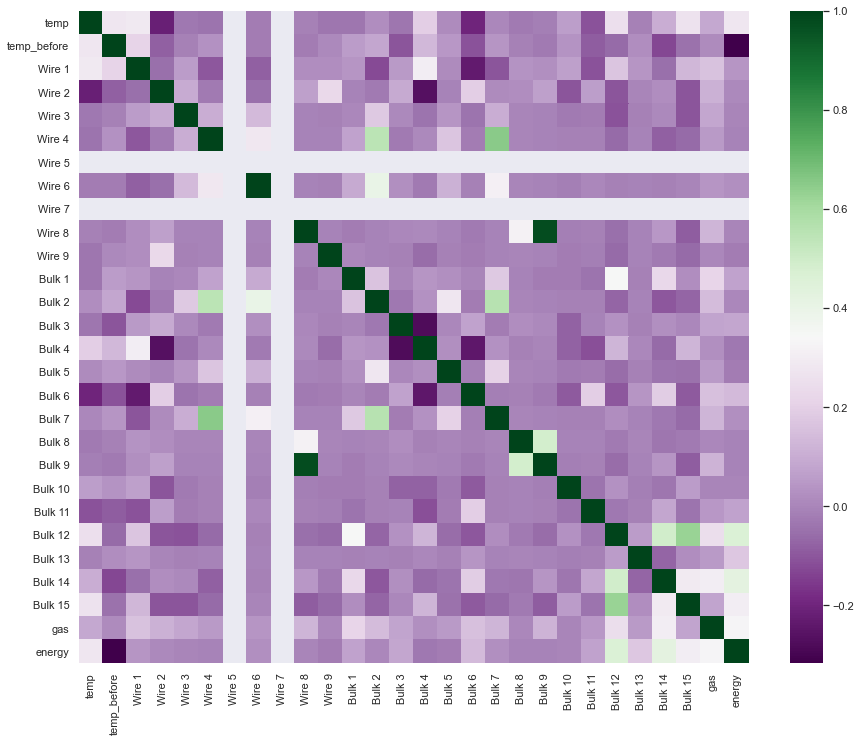

In [77]:
fig = plt.figure(figsize=(15,12))
sns.heatmap(df_full.corr(), cmap='PRGn')
plt.show()

Некоторые пересечения могут быть коллениарными. Две переменных коллинеарны, когда они находятся между собой в линейной зависимости, если коэффициент корреляции более 0.7. Произведём проверку

In [78]:
df_full.corr()[(df_full.corr() > 0.7) * (df_full.corr() != 1)].dropna(how='all').dropna(axis='columns', how='all')

C:\Users\Alexey\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,Wire 8,Bulk 9
Wire 8,NaN,0.974972
Bulk 9,0.974972,NaN


Проволока №8 и засыпка №9 крайне высоко коррелируют между собой. Чтобы избавиться от мультиколлинарности модели, необходимо исключить из датасета один из признаков. Удалим признак с наименьшей корреляцией с температурой

In [79]:
pd.DataFrame(df_full.corr()['temp']).query('index == "Wire 8" or index == "Bulk 9"')

,temp
Wire 8,-0.010897
Bulk 9,-0.016311


In [80]:
df_full = df_full.drop(['Wire 8'], axis=1)

Также замечено отсутствие корреляции у проволоки 5 и 7. Исследуем их

In [81]:
df_full['Wire 5'].describe()

count    2388.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Wire 5, dtype: float64

In [82]:
df_full['Wire 7'].describe()

count    2388.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Wire 7, dtype: float64

Удалим их за ненадобностью

In [83]:
df_full = df_full.drop(['Wire 5', 'Wire 7'], axis=1)

Разобьём датасет на обучающую и валидационную выборки

In [84]:
target = df_full['temp']
features = df_full.drop('temp', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RNG)

Произведём стандартизацию

In [85]:
numeric = features_test.columns
scaler = StandardScaler()
scaler.fit(features_train)

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

C:\Users\Alexey\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Alexey\anaconda3\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\Alexey\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

[Содержание](#title)

## 2. Обучение <a name="2"></a>

In [86]:
%%time
param_grid = {'max_depth': [md for md in range(1,22,3)], 'criterion': ['mae','mse']}
grid_tree = GridSearchCV(DecisionTreeRegressor(random_state=RNG), param_grid=param_grid, scoring='neg_mean_absolute_error', cv=4)
grid_tree.fit(features_train, target_train)
print(" Результат модели" )
    
print("\n MAE:\n", abs(grid_tree.best_score_))
    
print("\n Лучшие гиперпараметры:\n", grid_tree.best_params_)

 Результат модели

 MAE:
 6.704913456169738

 Лучшие гиперпараметры:
 {'criterion': 'mae', 'max_depth': 7}
Wall time: 3.62 s


Исследуем признаки, которые оказывают наибольшее влияние на модель

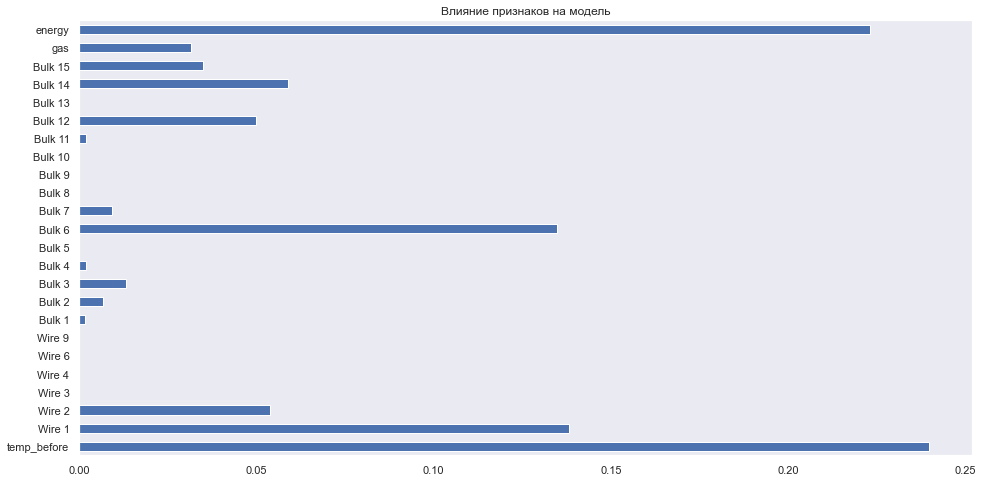

In [87]:
model_dt = DecisionTreeRegressor(random_state=RNG, criterion='mae', max_depth=7)
model_dt.fit(features_train, target_train)
feat_imp = pd.Series(model_dt.feature_importances_, index=features_train.columns)
fig = plt.figure(figsize=(16,8))
feat_imp.plot(kind='barh')
plt.grid(color = 'k', linewidth = 1, linestyle = '--')
plt.title("Влияние признаков на модель")
plt.show()

Влияние некоторых признаков крайне мало. Ограничим планку до 3% и пересоберём датасет

In [88]:
#заново создаём выборку, чтобы провести стандартизацию уже обрезанных данных
target = df_full['temp']
features = df_full.drop('temp', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RNG)

features_train = features_train[feat_imp[feat_imp > 0.03].index]
features_test = features_test[feat_imp[feat_imp > 0.03].index]

In [89]:
numeric = features_test.columns
scaler = StandardScaler()
scaler.fit(features_train)

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [90]:
features_train.head()

,temp_before,Wire 1,Wire 2,Bulk 6,Bulk 12,Bulk 14,Bulk 15,gas,energy
2263,0.769283,-0.626174,4.610863,2.764336,-1.338329,-1.835813,-1.404616,-0.832644,-1.030429
1871,1.552020,0.387266,0.644496,-0.399528,0.003824,-0.285846,0.445668,-0.385066,-0.835125
851,0.973475,-1.058721,-0.232375,-0.399528,-1.338329,-1.835813,-1.404616,-1.126176,-1.121395
295,-0.626030,-0.099465,-0.537690,-0.399528,0.023562,-0.031554,0.386742,0.636634,-0.412560
2268,-1.136510,-1.283811,1.635861,0.605464,0.016982,-0.140536,-0.202521,2.557720,3.184214


Продолжим обучение моделей по новой выборке

In [91]:
%%time
model_linear = LinearRegression()

final_score  = cross_val_score(model_linear, features_train, target_train, cv=4, scoring='neg_mean_absolute_error').mean()

print('MAE=', final_score)

MAE= -6.7707974535536986
Wall time: 58 ms


In [92]:
%%time
model_lgb = lgb.LGBMRegressor()

grid = {'learning_rate': [0.03, 0.05, 0.01],
        'num_leaves': [30, 50],
        'random_state': [RNG],
        'n_estimators': [1000]}

    
grid_lgb = GridSearchCV(estimator=model_lgb, param_grid = grid, scoring='neg_mean_absolute_error', cv=4)
grid_lgb.fit(features_train, target_train)
print(" Результат модели" )
    
print("\n MAE:\n", abs(grid_lgb.best_score_))
    
print("\n Лучшие гиперпараметры:\n", grid_lgb.best_params_)

 Результат модели

 MAE:
 6.2503747869930395

 Лучшие гиперпараметры:
 {'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 30, 'random_state': 34}
Wall time: 16 s


In [93]:
%%time
model_gb = GradientBoostingRegressor()

grid = {'learning_rate': [0.03, 0.05, 0.01],
        'subsample': [0.8, 1],
        'random_state': [RNG],
        'n_estimators': [1000]}

    
grid_gb = GridSearchCV(estimator=model_gb, param_grid = grid, scoring='neg_mean_absolute_error', cv=4)
grid_gb.fit(features_train, target_train)
print(" Результат модели" )
    
print("\n MAE:\n", abs(grid_gb.best_score_))
    
print("\n Лучшие гиперпараметры:\n", grid_gb.best_params_)

 Результат модели

 MAE:
 6.10556799895664

 Лучшие гиперпараметры:
 {'learning_rate': 0.01, 'n_estimators': 1000, 'random_state': 34, 'subsample': 0.8}
Wall time: 19.6 s


In [94]:
%%time
param_grid_forest = {'n_estimators': [ne for ne in range(5,56,15)], 'max_depth': [md for md in range(3,22,5)], 'criterion':['mae']}
grid_forest = GridSearchCV(RandomForestRegressor(random_state=RNG), param_grid=param_grid_forest, scoring='neg_mean_absolute_error', cv=4)
grid_forest.fit(features_train, target_train)
print(" Результат модели" )
    
print("\n MAE:\n", abs(grid_forest.best_score_))
    
print("\n Лучшие гиперпараметры:\n", grid_forest.best_params_)

 Результат модели

 MAE:
 6.1218481295365725

 Лучшие гиперпараметры:
 {'criterion': 'mae', 'max_depth': 8, 'n_estimators': 50}
Wall time: 1min 12s


In [95]:
%%time
model_cat = CatBoostRegressor(verbose=5000)

grid = {'learning_rate': [0.006, 0.016],
        'random_state': [RNG],
        'n_estimators': [5000],
        'loss_function': ['MAE']}

#'class_weight':['balanced']
#model.fit(features_train, target_train, cat_features=cat_features) 

    
grid_cat = GridSearchCV(estimator=model_cat, param_grid = grid, scoring='neg_mean_absolute_error', cv=4)
grid_cat.fit(features_train, target_train)
print(" Результат модели" )
    
print("\n MAE:\n", abs(grid_cat.best_score_))
    
print("\n Лучшие гиперпараметры:\n", grid_cat.best_params_)

0:	learn: 8.1104368	total: 63.5ms	remaining: 5m 17s
4999:	learn: 3.3679936	total: 8.91s	remaining: 0us
0:	learn: 8.0280824	total: 2.25ms	remaining: 11.2s
4999:	learn: 3.4688781	total: 8.7s	remaining: 0us
0:	learn: 7.9231934	total: 2.36ms	remaining: 11.8s
4999:	learn: 3.3464719	total: 9.06s	remaining: 0us
0:	learn: 7.8983442	total: 2.21ms	remaining: 11s
4999:	learn: 3.4640821	total: 9.95s	remaining: 0us
0:	learn: 8.0884934	total: 2.08ms	remaining: 10.4s
4999:	learn: 2.6069996	total: 8.72s	remaining: 0us
0:	learn: 8.0078739	total: 2.26ms	remaining: 11.3s
4999:	learn: 2.7163950	total: 8.49s	remaining: 0us
0:	learn: 7.9043922	total: 2.28ms	remaining: 11.4s
4999:	learn: 2.6928542	total: 8.6s	remaining: 0us
0:	learn: 7.8789692	total: 2.16ms	remaining: 10.8s
4999:	learn: 2.6934998	total: 8.32s	remaining: 0us
0:	learn: 7.9934909	total: 2.17ms	remaining: 10.8s
4999:	learn: 3.6827407	total: 9.16s	remaining: 0us
 Результат модели

 MAE:
 5.977632066154404

 Лучшие гиперпараметры:
 {'learning_rate

[Содержание](#title)

## 3. Теститорвание <a name="3"></a>

Наилучшие результаты метрики **MAE** показала модель `model_cat`. Произведём тестирование данной модели

In [96]:
model_catb = CatBoostRegressor(verbose=1000, learning_rate=0.006, random_state=RNG, n_estimators=5000, loss_function='MAE')
model_catb.fit(features_train, target_train)
prediction = model_catb.predict(features_test)
mean_absolute_error(target_test, prediction)

0:	learn: 7.9934909	total: 2.52ms	remaining: 12.6s
1000:	learn: 5.0407011	total: 1.92s	remaining: 7.66s
2000:	learn: 4.4532960	total: 3.81s	remaining: 5.71s
3000:	learn: 4.0854639	total: 5.67s	remaining: 3.78s
4000:	learn: 3.8592648	total: 7.55s	remaining: 1.89s
4999:	learn: 3.6827407	total: 9.36s	remaining: 0us


5.9812006688849095

Полученные результаты **MAE = 5.9812** входят в требуемые границы. Модель может применяться в рабочем процессе.

Отобразим результаты всех полученных моделей

In [97]:
data = {'Модель': ['DecisionTreeRegressor', 'LinearRegression', 'LGBMRegressor',\
                 'GradientBoostingRegressor', 'RandomForestRegressor', 'CatBoostRegressor'],\
        'Гиперпараметры': [grid_tree.best_params_, 0, grid_lgb.best_params_, grid_gb.best_params_,\
                           grid_forest.best_params_, grid_cat.best_params_],\
       'Средняя абс. ошибка (cross_val)': [grid_tree.best_score_, final_score, grid_lgb.best_score_, grid_gb.best_score_,\
                           grid_forest.best_score_, grid_cat.best_score_]}
research = pd.DataFrame(data=data)

In [98]:
research['Средняя абс. ошибка (cross_val)'] = np.abs(research['Средняя абс. ошибка (cross_val)'])
research

,Модель,Гиперпараметры,Средняя абс. ошибка (cross_val)
0,DecisionTreeRegressor,"{'criterion': 'mae', 'max_depth': 7}",6.704913
1,LinearRegression,0,6.770797
2,LGBMRegressor,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",6.250375
3,GradientBoostingRegressor,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",6.105568
4,RandomForestRegressor,"{'criterion': 'mae', 'max_depth': 8, 'n_estima...",6.121848
5,CatBoostRegressor,"{'learning_rate': 0.006, 'loss_function': 'MAE...",5.977632


[Содержание](#title)